# Makemore

A character-level language model that is learnt in an auto-regressive fashion.    
The model is a multi-layer perceptron (MLP), but the focus is on MLP internals, scrutinizing forward pass activation statistics, backward pass gradients, and the pitfalls of improper scaling; resulting in an implementation of batch normalization.

**<span style="color: red;">NOTE</span>: The visualizations for diagnosing neural network training (at the bottom of the notebook) are one of the most important project-agnostic takeaways from `makemore`**.

Takeaways:
1. How `BatchNorm1D`, a non-trivial neural-net machinery, is implemented.
2. PyTorch API like neural network code.
3. Visual diagnostic tools.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

SEED = 2147483647

In [2]:
# read in all the words
words = open('./data/names.txt', 'r').read().splitlines()
print(f"A few words: {words[:5]}")
print(f"Length of words: {len(words)}")


A few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Length of words: 32033


In [3]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# Build the dataset(s).
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Weight Initializations

The initial loss is expected to be random chance: `-torch.tensor(1/27).log()=3.2958`.     
But we were seeing `~27`.    
This is because the initial weights were too large.    
We can fix this by scaling the weights down by `0.1`/ `0.01`, which helps for `W2` and `b2`.    
The issue with `W1` and `b1` is much more subtle.    
Since they pass through `tanh`, we need to scale them down to avoid saturation.    
The most popular method is Kaiming init, which uses $\frac{\text{gain}}{\sqrt{\text{fan}_{\text{in}}}}$ scaling.    
The $\text{gain}$ for `tanh` is `5/3`.

In [5]:
# MLP revisited
n_embd = 10 # Character embedding vector dimensionality.
n_hidden = 200 # Hidden layer neurons.

g = torch.Generator().manual_seed(SEED) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# Made obsolete by BatchNorm. No point in adding, then subtracting out during normalization.
# bnbias replaces b1.
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
# bngain and bnbias help to scale and shift the normalized values.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# bnmean_running and bnstd_running are the running mean and std, used during inference.
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


### Batch Normalization.
If we want to be able to initialize weights to standard normal, i.e., $\mathcal{N}(\mu=0, \sigma^2=1)$,    
we can simply normalize the activations since it is a differentiable operation.    
This helps us control the statistics in the network.

`NOTE`:
1. The network is simple enough that the smart initializations get us most of the gains. BN may not result in significant improvements.
2. BN makes every input a function of the batch (by normalizing using batch statistics). This results in a slight perturbation of the input as seen by the network. This is a form of regularization, and can be seen as a form of data augmentation (jittering the sample by batch statistics).

Reference:
1. [BatchNorm1D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

In [6]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # Sample a minibatch.
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Forward.
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # Backward.
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Update.
  lr = 0.1 if i < 60000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats.
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 100000: 3.3239
  10000/ 100000: 2.0322
  20000/ 100000: 2.5675


KeyboardInterrupt: 

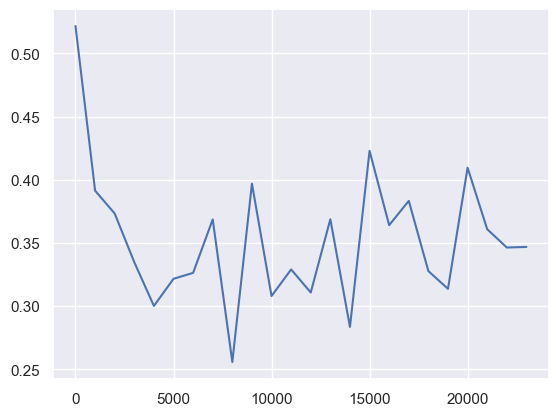

In [7]:
PLT_STEP = 1000
plt.plot(torch.arange(len(lossi))[::PLT_STEP], lossi[::PLT_STEP]);

In [8]:
# Calibrate BatchNorm at the end of training
# bnmean_running and bnstd_running make this explicit computation obsolete.
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'Train': (Xtr, Ytr),
    'Val': (Xdev, Ydev),
    'Test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f"{split} Loss: {loss.item():.4f}")

split_loss('Train')
split_loss('Val')

Train Loss: 2.2159
Val Loss: 2.2297


### PyTorch-ifying the code.

In [10]:
from makemore_mlp_utils import Linear, BatchNorm1d, Tanh

# Define hyperparameters.
context = 3
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(SEED) # for reproducibility

# Define network layers.
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)]

# Initialize weights.
with torch.no_grad():
    # Make last layer less confident to prevent repetitive or predictable text generation.
    # Make model less certain about its predictions.
    # Encourage the model to generate diverse text.
    layers[-1].gamma *= .1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)/((n_embd * context)**0.5)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total model parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
  p.requires_grad = True

Total model parameters: 47024


### Training loop.

In [30]:
max_steps = 10000
batch_size = 32
lossi = []
ud = []
print_stats = max_steps // 10

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward.
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward.
    for layer in layers:
        # `retain_grad()` allows us to retain tensor gradients after a forward pass.
        # Useful when we want to examine gradients wrt intermediate values in a computation graph.
        # By default, PyTorch only keeps the gradients of leaf tensors, but
        # if we call retain_grad() on a non-leaf tensor, its gradients will also be retained.
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update.
    lr = 0.1 if i<int(.75*max_steps) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats.
    if i%print_stats == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  10000: 1.7836
   1000/  10000: 2.2740
   2000/  10000: 1.9035
   3000/  10000: 2.2058
   4000/  10000: 2.4004
   5000/  10000: 2.0319
   6000/  10000: 1.5924
   7000/  10000: 2.0220
   8000/  10000: 1.9196
   9000/  10000: 1.8437


### Visualizations.

#### Visualize `tanh` activations.

layer 2 (      Tanh): mean +0.03, std 0.82, saturated: 34.75%
layer 5 (      Tanh): mean +0.02, std 0.86, saturated: 44.09%
layer 8 (      Tanh): mean -0.01, std 0.87, saturated: 44.41%
layer 11 (      Tanh): mean +0.02, std 0.86, saturated: 44.19%
layer 14 (      Tanh): mean -0.00, std 0.86, saturated: 40.91%


Text(0.5, 1.0, 'activation distribution')

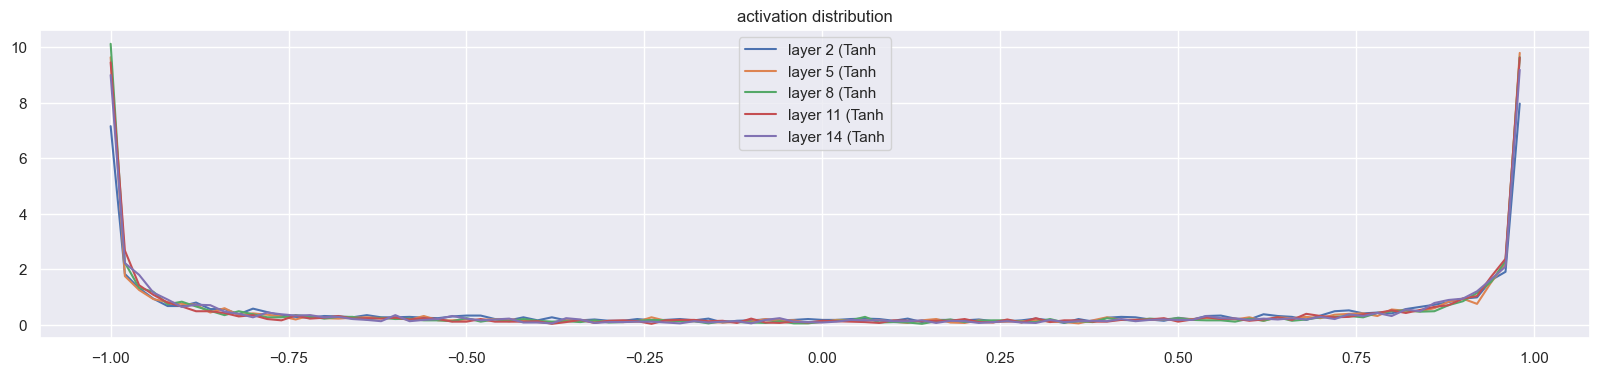

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i,
                                                                        layer.__class__.__name__,
                                                                        t.mean(),
                                                                        t.std(),
                                                                        (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#### Visualize `tanh` gradients.

layer 2 (      Tanh): mean +0.000006, std 1.873077e-03
layer 5 (      Tanh): mean +0.000025, std 1.732981e-03
layer 8 (      Tanh): mean +0.000025, std 1.664621e-03
layer 11 (      Tanh): mean +0.000001, std 1.724028e-03
layer 14 (      Tanh): mean -0.000070, std 2.363701e-03


Text(0.5, 1.0, 'gradient distribution')

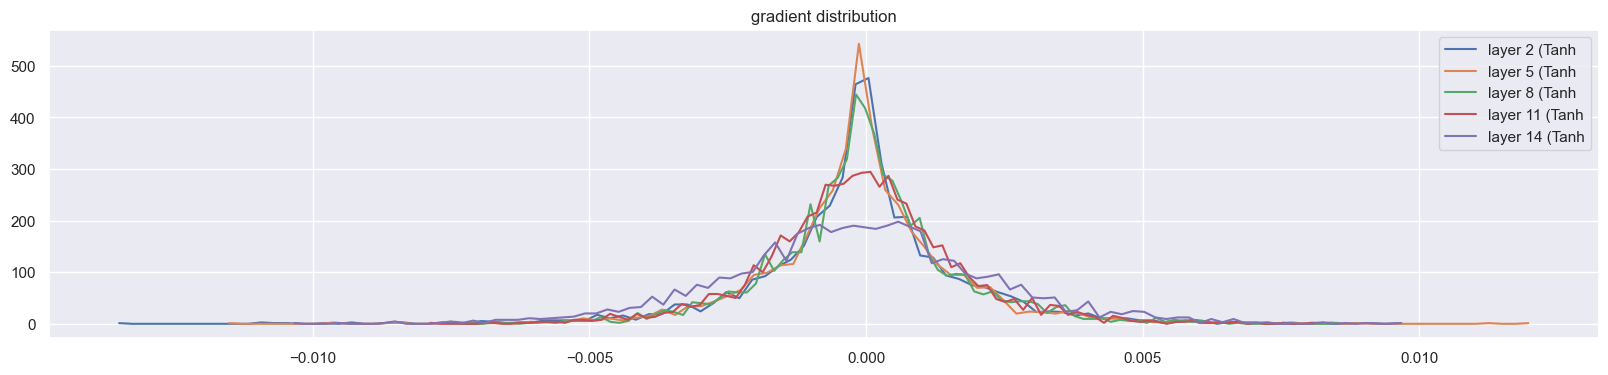

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

#### Visualizing weights of `Linear` layers.
(Skipping biases and BN gamma/beta.)    

The $\frac{\text{gradient}}{\text{data}}$ ratio is a good indicator of how much the weights are changing wrt the data.    
It also helps to track this because $\text{LR}\cdot\text{gradient}$ updates are applied to $\text{data}$.

weight   (27, 10) | mean +0.000786 | std 1.004683e-02 | grad:data ratio 9.457502e-03
weight  (30, 100) | mean -0.000223 | std 9.577811e-03 | grad:data ratio 4.138152e-02
weight (100, 100) | mean +0.000046 | std 5.295065e-03 | grad:data ratio 4.253031e-02
weight (100, 100) | mean +0.000015 | std 4.964324e-03 | grad:data ratio 4.409271e-02
weight (100, 100) | mean -0.000013 | std 5.070389e-03 | grad:data ratio 4.849866e-02
weight (100, 100) | mean +0.000019 | std 5.293777e-03 | grad:data ratio 5.078971e-02
weight  (100, 27) | mean -0.000022 | std 1.097294e-02 | grad:data ratio 5.996471e-02


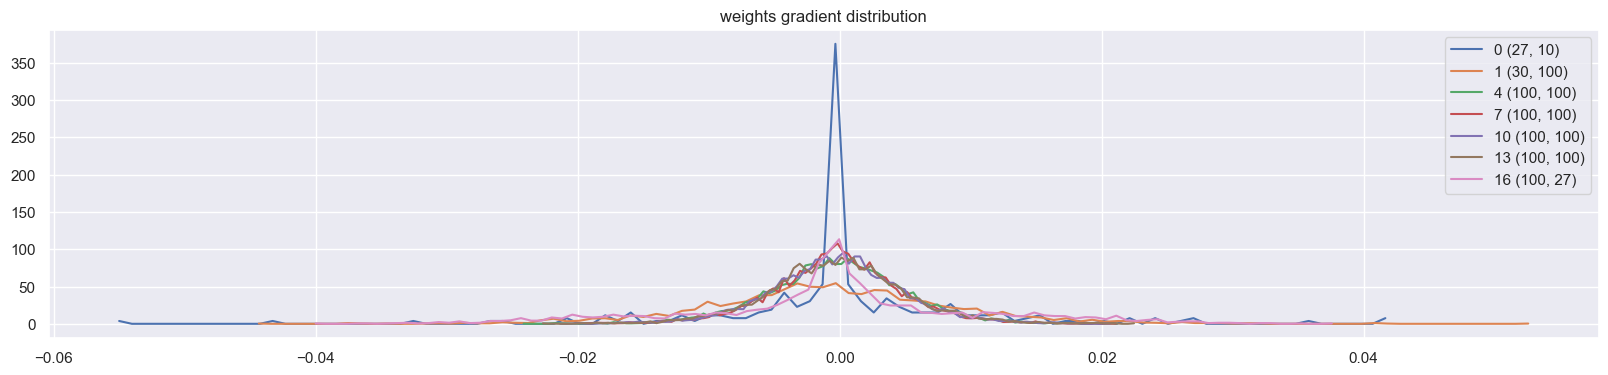

In [33]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),
                                                                    t.mean(),
                                                                    t.std(),
                                                                    t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### Visualize `update` ratios.



The $\log_{10}(\frac{(\text{lr}\times\text{param}_{\text{grad}}).\text{std}()}{\text{param}_{\text{data}}.\text{std}()})$ ratio for a layer is a good indicator of how much the weights are changing wrt the data.    
Numbers in the range $[-3, -2]$ are good since they indicate that the tensor is being updated at a rate of $0.01$/ $0.001$ of their values.


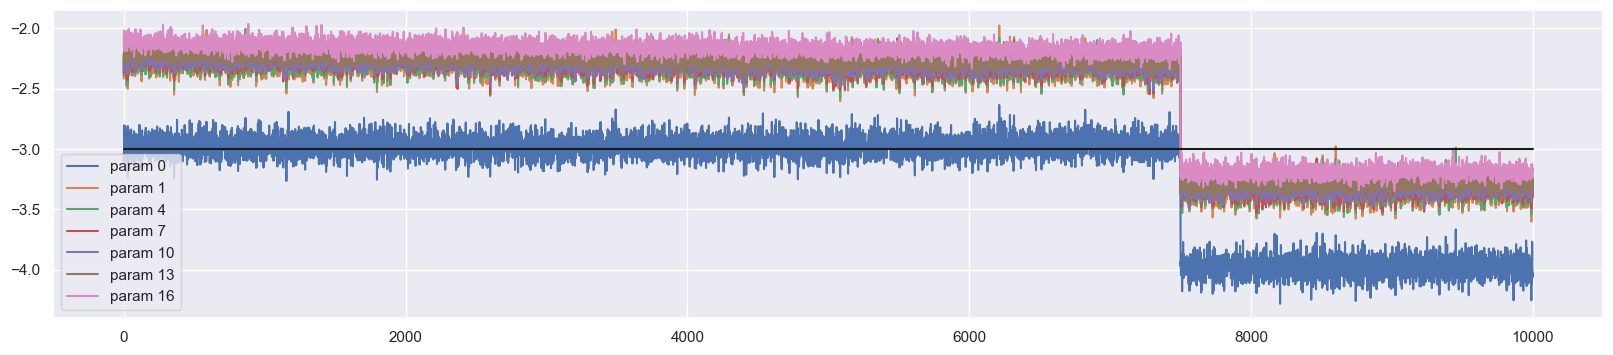

In [47]:
PLT_STEP = 100
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    data = [ud[j][i] for j in range(len(ud))]
    plt.plot(data)
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.080047845840454
val 2.119683027267456


### Sample from the model

In [36]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
seel.
ndhayla.
remmastendraegen.
ched.
elin.
shi.
jenne.
elisson.
arleigh.
malaia.
noshubergiaghan.
trick.
welle.
jetton.
kuba.
ged.
ryyah.
fael.
yuma.
